<a href="https://colab.research.google.com/github/akhilapidikiti/AE/blob/main/fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
len(os.listdir('/content/drive/MyDrive/dev_data_ToyCar/ToyCar/train'))

4000

In [ ]:
Normal wav -> 4000    /content/drive/MyDrive/dev_data_ToyCar/ToyCar/train
Abnormal wav -> 1059  /content/drive/MyDrive/ToyCar_abnormal_wav

1400

In [ ]:
#Augmented only abnormal data

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Reshape, Conv2D, Input, BatchNormalization, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, LSTM, Conv1D, Flatten, TimeDistributed, InputLayer
#from keras.models import Model, load_model
from tensorflow.keras.models import Model, load_model   # tensorflow.keras
from tensorflow.keras import callbacks
from google.colab.patches import cv2_imshow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam               
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
import torch   

In [ ]:
mel_bins =  128 # 128
frames =  313
skip_frames =  1
n_fft = 1024
hop_length =  512
win_length = 1024
power = 2.0
sr = 16000

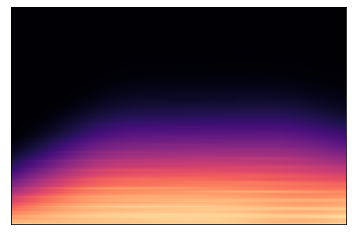

In [58]:
y, sr = librosa.load('/content/drive/MyDrive/dev_data_ToyCar/ToyCar/train/normal_id_01_00000000.wav')
hop_length = 512
oenv = librosa.onset.onset_strength(y=x, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                      hop_length=hop_length)
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length, cmap='magma')
fig.savefig('/content/drive/MyDrive/'+'.tgram.png')

In [ ]:
tempogram

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 9.26103244e-01,  9.26131743e-01,  9.26160999e-01, ...,
         9.23919457e-01,  9.24025145e-01,  9.24135314e-01],
       [ 8.35146499e-01,  8.35228788e-01,  8.35312683e-01, ...,
         8.17012232e-01,  8.17093822e-01,  8.17188732e-01],
       ...,
       [-3.55880959e-17,  1.29598394e-16,  7.43419070e-17, ...,
         3.13185383e-12,  2.52804265e-12,  1.98535660e-12],
       [-1.45015866e-17,  1.56631366e-16,  1.36059843e-16, ...,
         3.42062297e-13,  2.20111522e-13,  1.52400340e-13],
       [-9.51015574e-18,  1.43454655e-16,  1.54980429e-16, ...,
        -1.28365426e-17,  5.22970381e-17,  1.84499434e-16]])

In [53]:
#@title
x_wav.shape

torch.Size([1, 1, 220500])

In [ ]:
#@title
x_wav = x[None, None, :sr * 10]
x_wav = torch.from_numpy(x_wav)
x_wav = x_wav.float()

In [ ]:
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.2)

In [ ]:
from tensorflow.keras.models import Sequential
model=Sequential()

#model.add(Conv1D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(176000,)))
model.add(Conv1D(1, mel_bins,padding="same",activation="relu",input_shape=tempogram.shape ))
model.add(BatchNormalization())
model.add(Conv1D(1, mel_bins,padding="same",activation=lrelu,input_shape=tempogram.shape ))
model.add(BatchNormalization())
model.add(Conv1D(1, mel_bins,padding="same",activation=lrelu,input_shape=tempogram.shape ))
model.add(BatchNormalization())
model.add(Conv1D(1, mel_bins,padding="same",activation=lrelu,input_shape=tempogram.shape ))

In [65]:
import cv2
import numpy as np

img1 = cv2.imread('/content/drive/MyDrive/'+'.tgram.png')
img2 = cv2.imread('/content/drive/MyDrive/ToyCar/Normal/normal_id_01_00000000.wav_mel_spec.png')
#Img2 = cv2.resize (img2, (480331)) # unified picture size

dst = cv2.addWeighted(img1,0.5,img2,0.5,0)


In [66]:
import pywt
import cv2
import numpy as np

# This function does the coefficient fusing according to the fusion method
def fuseCoeff(cooef1, cooef2, method):

    if (method == 'mean'):
        cooef = (cooef1 + cooef2) / 2
    elif (method == 'min'):
        cooef = np.minimum(cooef1,cooef2)
    elif (method == 'max'):
        cooef = np.maximum(cooef1,cooef2)
    else:
        cooef = []

    return cooef


# Params
FUSION_METHOD = 'mean' # Can be 'min' || 'max || anything you choose according theory

# Read the two image
I1 = cv2.imread('/content/drive/MyDrive/'+'.tgram.png',0)
I2 = cv2.imread('/content/drive/MyDrive/ToyCar/Normal/normal_id_01_00000000.wav_mel_spec.png',0)
I2 = cv2.resize(I2,I1.shape) # I do this just because i used two random images

## Fusion algo

# First: Do wavelet transform on each image
wavelet = 'db1'
cooef1 = pywt.wavedec2(I1[:,:], wavelet)
cooef2 = pywt.wavedec2(I2[:,:], wavelet)

# Second: for each level in both image do the fusion according to the desire option
fusedCooef = []
for i in range(len(cooef1)-1):

    # The first values in each decomposition is the apprximation values of the top level
    if(i == 0):

        fusedCooef.append(fuseCoeff(cooef1[0],cooef2[0],FUSION_METHOD))

    else:

        # For the rest of the levels we have tupels with 3 coeeficents
        c1 = fuseCoeff(cooef1[i][0],cooef2[i][0],FUSION_METHOD)
        c2 = fuseCoeff(cooef1[i][1], cooef2[i][1], FUSION_METHOD)
        c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], FUSION_METHOD)

        fusedCooef.append((c1,c2,c3))
# Third: After we fused the cooefficent we nned to transfor back to get the image
fusedImage = pywt.waverec2(fusedCooef, wavelet)

# Forth: normmalize values to be in uint8
fusedImage = np.multiply(np.divide(fusedImage - np.min(fusedImage),(np.max(fusedImage) - np.min(fusedImage))),255)
fusedImage = fusedImage.astype(np.uint8)

# Fith: Show image
cv2.imshow("win",fusedImage)

ValueError: ignored

In [69]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

def channelTransform(ch1,ch2, shape):
    cooef1 = pywt.dwt2(ch1, 'db5', mode = 'periodization')
    cooef2 = pywt.dwt2(ch2, 'db5', mode = 'periodization')
    cA1, (cH1, cV1, cD1) = cooef1
    cA2, (cH2, cV2, cD2) = cooef2

    cA = (cA1+cA2)/2
    cH = (cH1 +cH2)/2
    cV = (cV1+cV2)/2
    cD = (cD1+cD2)/2
    fincoC = cA, (cH,cV,cD)
    outImageC = pywt.idwt2(fincoC, 'db5', mode = 'periodization')
    outImageC = cv2.resize(outImageC,(shape[0],shape[1])) 
    return outImageC

In [78]:
def fusion(img1, img2):
    # Params
    FUSION_METHOD = 'mean' # Can be 'min' || 'max || anything you choose according theory

    # Read the two image
    I1 = cv2.imread(img1)
    I2 = cv2.imread(img2)

    # Resizing image if both are in different shapes
    I2 = cv2.resize(I2,(I1.shape[1],I1.shape[0])) 
    
    print (I1.shape)
    print (I2.shape)
    ## Seperating channels
    iR1 = I1.copy()
    iR1[:,:,1] = iR1[:,:,2] = 0
    iR2 = I2.copy()
    iR2[:,:,1] = iR2[:,:,2] = 0

    iG1 = I1.copy()
    iG1[:,:,0] = iG1[:,:,2] = 0
    iG2 = I2.copy()
    iG2[:,:,0] = iG2[:,:,2] = 0

    iB1 = I1.copy()
    iB1[:,:,0] = iB1[:,:,1] = 0
    iB2 = I2.copy()
    iB2[:,:,0] = iB2[:,:,1] = 0

    shape = (I1.shape[1], I1.shape[0])
    # Wavelet transformation on red channel
    outImageR = channelTransform(iR1, iR2, shape)
    outImageG = channelTransform(iG1, iG2, shape)
    outImageB = channelTransform(iB1, iB2, shape)

    outImage = I1.copy()
    outImage[:,:,0] = outImage[:,:,1] = outImage[:,:,2] = 0
    outImage[:,:,0] = outImageR[:,:,0]
    outImage[:,:,1] = outImageG[:,:,1]
    outImage[:,:,2] = outImageB[:,:,2] 

    outImage = np.multiply(np.divide(outImage - np.min(outImage),(np.max(outImage) - np.min(outImage))),255)
    outImage = outImage.astype(np.uint8)

    x = random.randint(1000, 2000)
    loc = '/content/drive/MyDrive/'+str(x)+'fusedimg.png'
    cv2.imwrite(loc,outImage)

    return loc

In [79]:
fusion('/content/drive/MyDrive/'+'.tgram.png','/content/drive/MyDrive/ToyCar/Normal/normal_id_01_00000000.wav_mel_spec.png')

(288, 432, 3)
(288, 432, 3)


'/content/drive/MyDrive/1064fusedimg.png'

In [77]:
import cv2
I = cv2.imread('demo/out1231.jpg')

TypeError: ignored

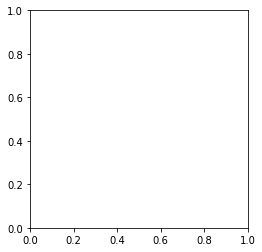

In [73]:
plt.imshow(I)
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/akhilapidikiti/AE.git

Cloning into 'AE'...


In [3]:
sudo apt install git

SyntaxError: ignored

In [4]:
git add /content/drive/MyDrive

SyntaxError: ignored